# Стратегия сети фитнес-центров «Культурист-датасаентист» взаимодействия с клиентами 

### Описание и цель проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Необходимо провести анализ и подготовить план действий по удержанию клиентов.  
### Декомпозиция проекта
1. Зарузить данные
2. Провести предобработку данных
3. Провести исследовательский анализ данных
4. Построить модель прогнозирования оттока клиентов
5. Создать кластеризацию клиентов
6. Подготовить выводы и рекомендации
### Описание данных
* gender — пол
* Near_Location — проживание или работа в районе, где находится фитнес-центр
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* Phone — наличие контактного телефона
* Age — возраст
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)
* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год)
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
* Group_visits — факт посещения групповых занятий
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон
* Сhurn — факт оттока в текущем месяце


## Загрузка данных и импорт библиотек

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shap 

In [4]:
try:
    data = pd.read_csv('gym_churn.csv')
except IOError:
    print('error')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
data.shape

(4000, 14)

In [7]:
data.columns = data.columns.str.lower()

Данные успешно были загружены, пропуски не обнаружены. Тип данных везде соответствует. Изменили названия переменных в соответствии со стилистическими правилами языка. 

## Исследовательский анализ данных (EDA)

In [10]:
data.duplicated().sum()

0

Пропуски и дубликаты не обнаружены. 

In [12]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [13]:
data['churn'].value_counts()

churn
0    2939
1    1061
Name: count, dtype: int64

Доля оттока составила 36%

### Cредние значения признаков в двух группах — тех, кто ушел в отток (1) и тех, кто остался (0)

In [16]:
round(data.groupby('churn').mean().T,2)

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Согласно полученным данным: сотрудники компании-партнера клуба остаются чаще; клиенты, пришедшие по акции "приведи друга" остаются чаще; чем дольше срок контракта, заключенного в клубе тем сильнее это держит клиентов; посетители, посещающие групповые занятия остаются чаще; дополнительными услугами клуба пользовались обе группы клиентов, но потратили немного больше действующие клиенты; активные пользователи посещяют клуб в среднем 2 раза в неделю, когда у "отвалившихся" пользователей это значение явлется 1. 


### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался

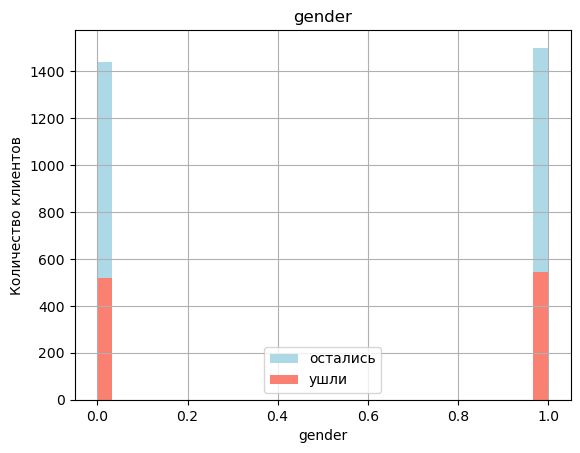

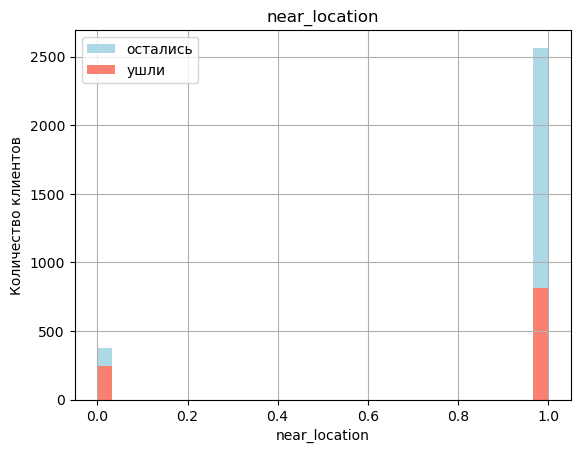

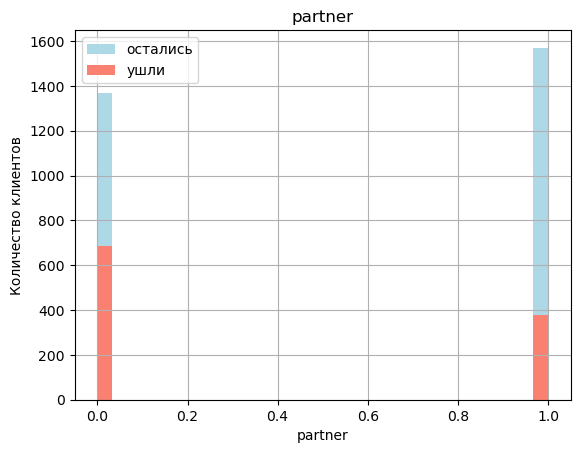

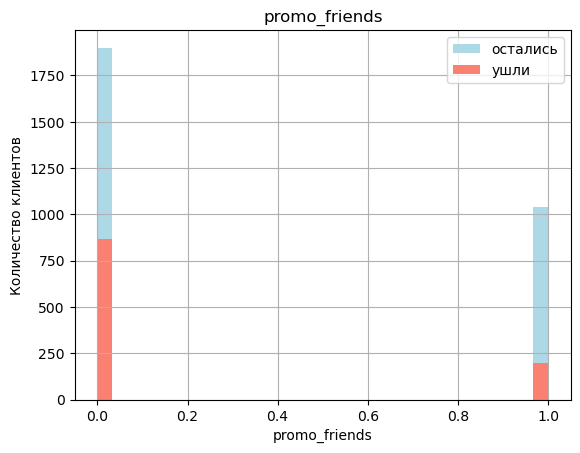

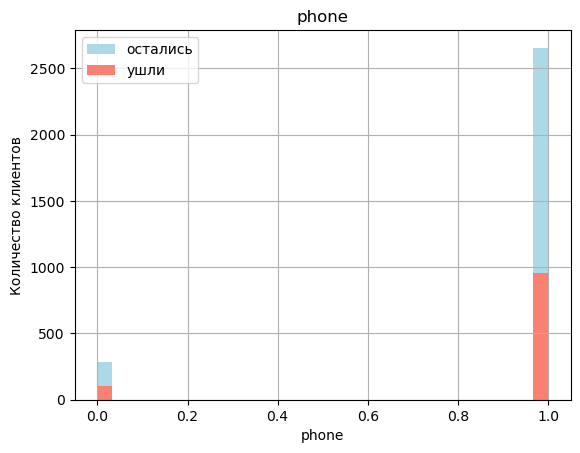

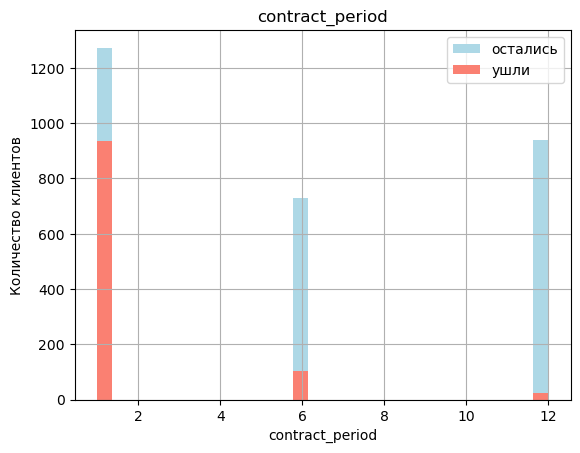

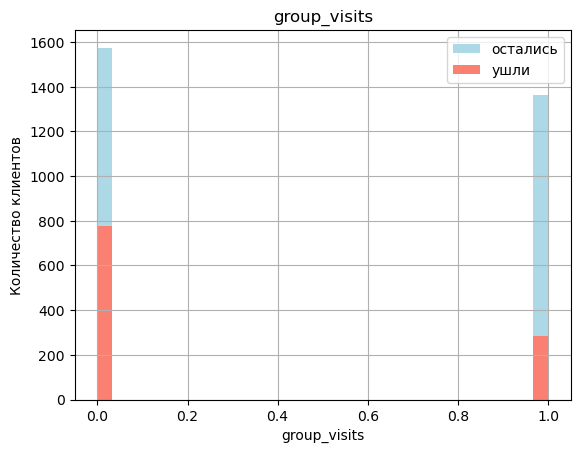

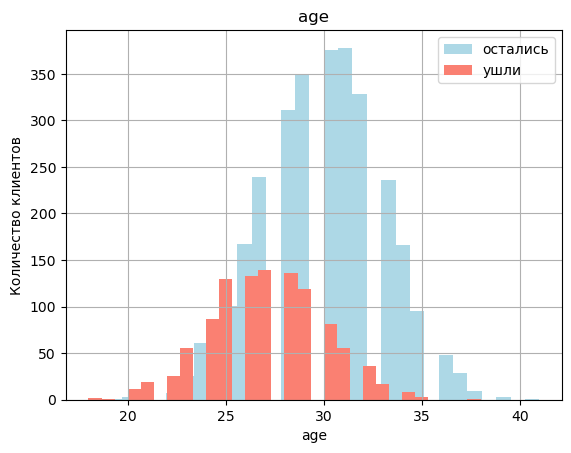

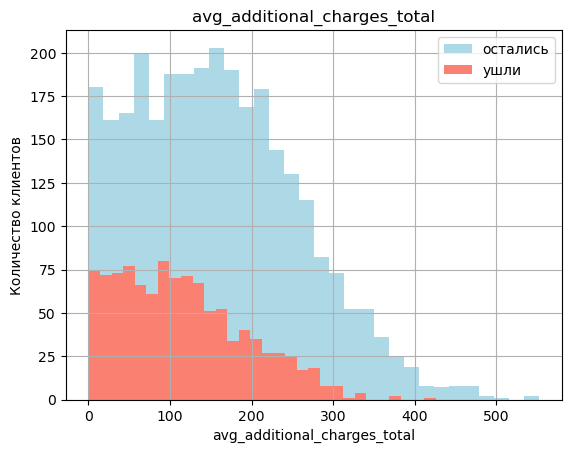

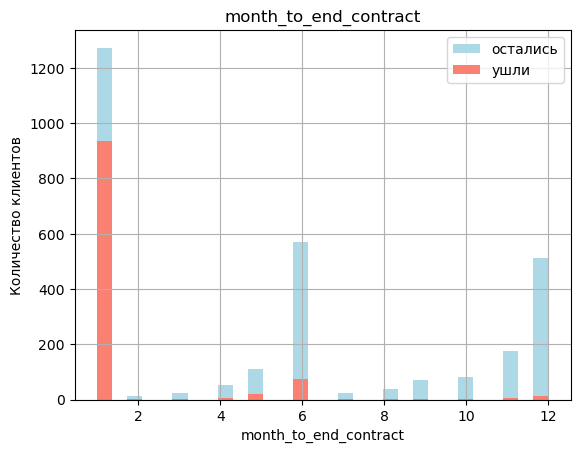

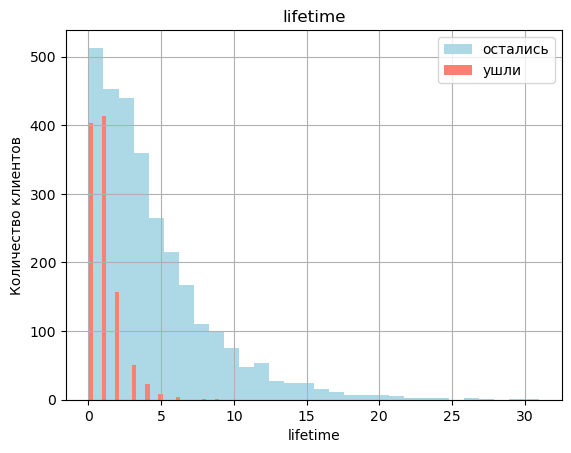

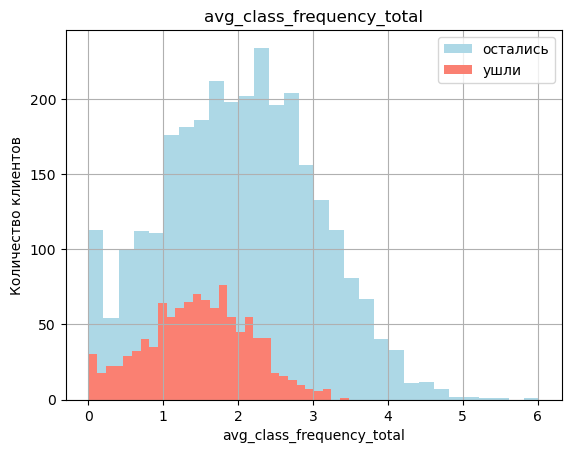

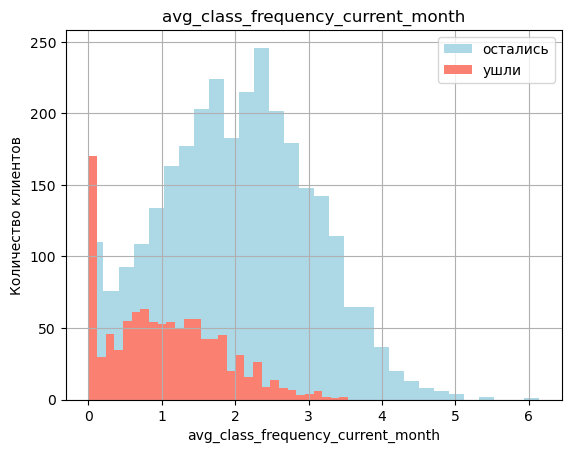

In [19]:
for col in data.drop('churn', axis = 1).columns:
    plt.hist(data.loc[data['churn'] == 0, col], label='остались', bins=30, color = 'lightblue');
    plt.hist(data.loc[data['churn'] == 1, col], label='ушли', bins=30, color = 'salmon');
    plt.title(label=col);
    plt.xlabel(col);
    plt.ylabel('Количество клиентов')
    plt.legend();
    plt.grid();
    plt.show();

Выводы по построенным гистограммам:
На мой взгляд существенным признаком является contract_period. В случаях когда продолжительность контракта от полугода и выше процент оттока посетителей уменьшается. 
Также признак group_visits является показательным. Люди, посещяющие групповые занятие дольше сохраняют мотивацию. 
Говоря о lifetime, здесь есть логичная взаимосвязь, чем больше люди ходят, тем меньше верооятность их оттока. 

### Матрица корреляций 

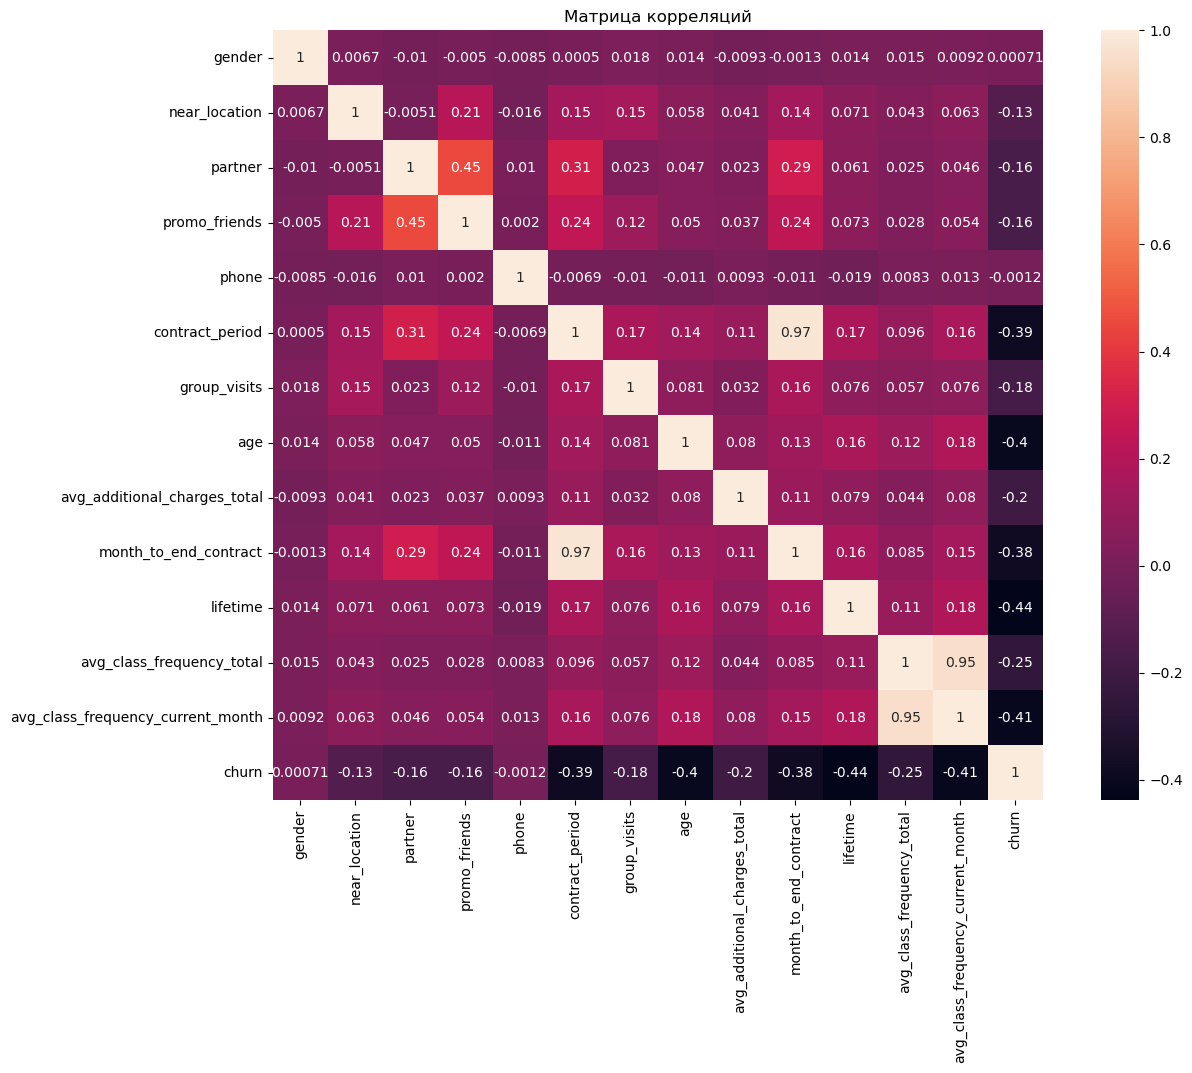

In [22]:
data_corr = data.corr()
plt.figure(figsize=(15, 10));
sns.heatmap(data_corr,annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

Можем выделить высокое значение корреляции (около 1) у признаков month_to_end_contract и contract_period, также у признаков avg_class_frequency_total и avg_class_frequency_current_month. В данной модели может наблюдать нестрогую мультиколлинеарность. Так как она может затруднить работу модели и/или привести к искажению результатов, постараемся от нее избавиться. Удалим признаки avg_class_frequency_current_month и month_to_end_contract. Все, кроме одного признака gender имеют отрицательную корреляцию с нашей целевой переменной (churn). 

In [24]:
new_data = data.drop(['avg_class_frequency_current_month', 'month_to_end_contract'], axis=1)
new_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


### Промежуточный вывод
Был проведена первичная предобработка данных и выполнен исследовательский анализ данных. Установили размер датасета (4000;14). В наш датафрейм вошли только числовые признаки. Пропущенные значения, дубликаты и выбросы не были обнаружены. Обнаружили сильную корреляцию между несколькими признаками и удалили их. Выявили, что с целевой переменной практически все признаки имеют отрицательную корреляцию.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Разбиение данных на обучающую и валидационную выборку функцией

In [29]:
#разделим данные на признаки (матрица X) и целевую переменную (y)
X = new_data.drop('churn', axis = 1)
y = new_data['churn']

In [30]:
#разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение модели на train-выборке

Обучение проведем двумя способами: с использованием логистической регрессией и с использованием случайного леса.

In [34]:
#обучение с использованием логистической регрессии
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train)

predictions = model.predict(X_test_st)

In [35]:
#обучение с использованием случайного леса 
model_RF = RandomForestClassifier(n_estimators = 100, random_state=0)
model_RF.fit(X_train_st, y_train)

predictions_RF =  model_RF.predict(X_test_st)

### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке

In [37]:
#оценка метрик логистической регрессии 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.91
Precision: 0.83
Recall: 0.83
F1: 0.83


In [38]:
#оценка метрик случайного леса 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_RF)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions_RF)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_RF)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions_RF)))

Accuracy: 0.89
Precision: 0.81
Recall: 0.79
F1: 0.80


По всем метрикам модель логистической регрессии превзошла модель случайного леса. Совсем немного правда, но превзошла. 

## Кластеризация клиентов

In [41]:
X = data.drop('churn', axis = 1)

### Стандартизация данных

In [43]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков. Дендрограмма. 

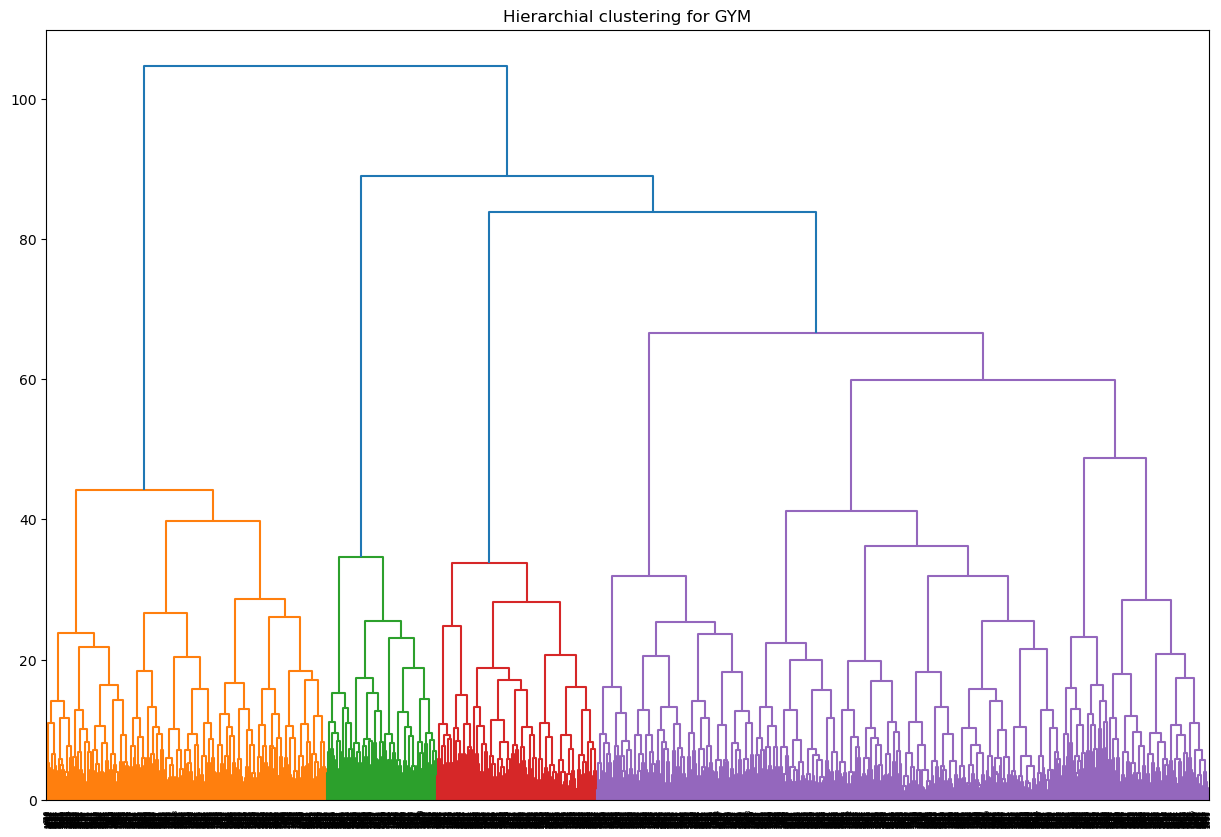

In [45]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

На основании полученной дендрограммы данные можем разделить на 4 кластера. 

### Обучение модели кластеризации на основании алгоритма K-Means

Установим число кластеров равным пяти. 

In [49]:
km = KMeans(n_clusters = 5, random_state = 0) 
labels = km.fit_predict(X_sc)

In [50]:
data['cluster_km'] = labels
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


### Cредние значения признаков для кластеров

In [52]:
data['cluster_km'].value_counts()

cluster_km
0    1138
2     941
1     746
3     631
4     544
Name: count, dtype: int64

Больше всего клиентов попали в 3 и 0 кластеры. 

In [60]:
round(data.groupby('cluster_km').mean().T, 2)

cluster_km,0,1,2,3,4
gender,0.49,0.59,0.50,0.48,0.50
near_location,1.00,0.97,0.94,1.00,0.00
partner,0.24,0.29,0.74,0.80,0.47
promo_friends,0.01,0.12,0.49,1.00,0.08
phone,0.90,0.90,0.90,0.91,0.92
contract_period,1.98,2.90,11.87,3.08,2.21
group_visits,0.33,0.48,0.55,0.45,0.22
age,28.24,30.34,29.91,29.05,28.48
avg_additional_charges_total,130.88,164.19,165.15,139.86,133.63
month_to_end_contract,1.90,2.65,10.85,2.87,2.07


На первый взгляд наиболее привлекательным для нас является второй кластер. В оценку попали только важные признаки в нашем случае. Это contract_period, month_to_end_contract, avg_class_frequency_current_month, avg_additional_charges_total. Прежде всего второй кластер привлекает своим значением contract_period = 11.87. При этом lifetime равняется только 4.74. Также этот кластер практически на равне с кластером 1 приносит наибольшую выручку от других услуг фитнес-центра. Посещают клуб в среднем два раза в неделю. Лидером по посещениям является 1 кластер там число посещений в неделю равняется 2.94.

In [63]:
round(silhouette_score(X_sc, labels),2)

0.13

Значение метрики получилось равным 0.13. Определенно не самая качественная кластеризация получилась. 

### Распределения признаков для кластеров

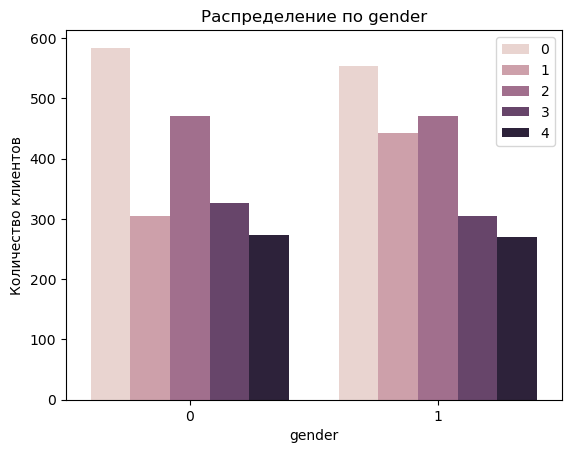

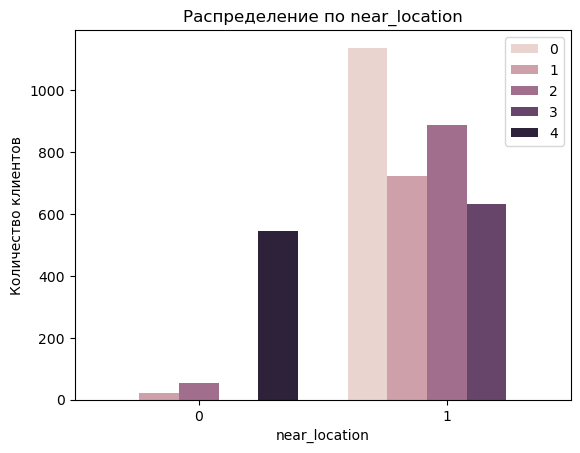

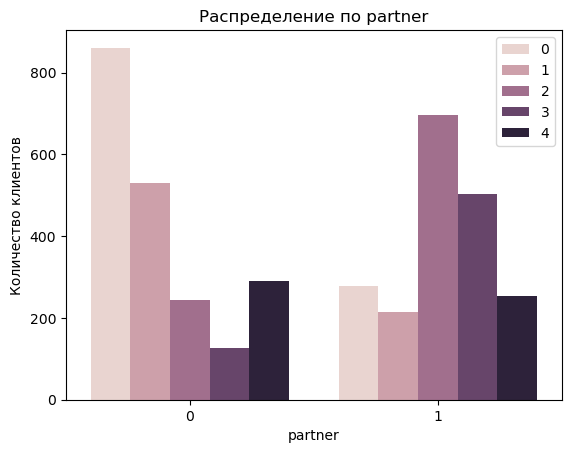

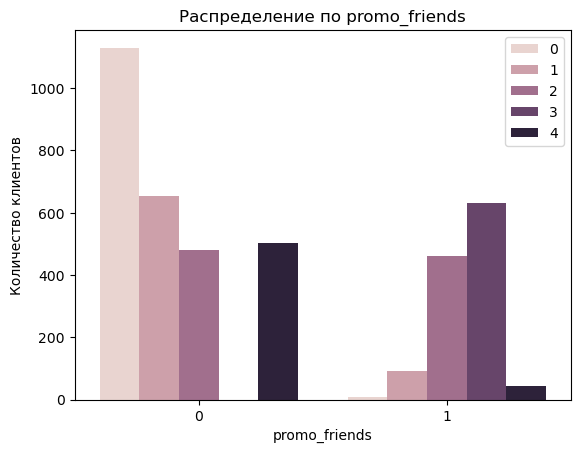

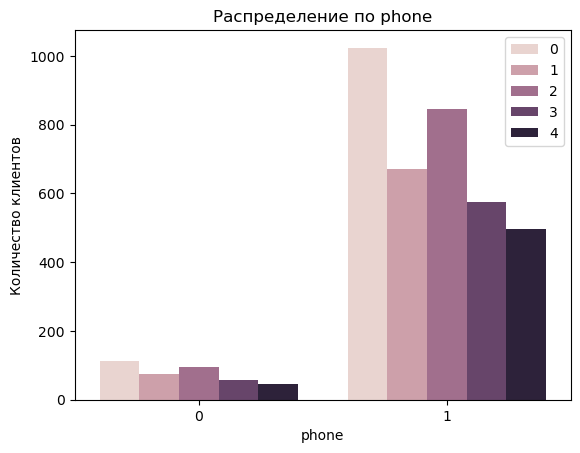

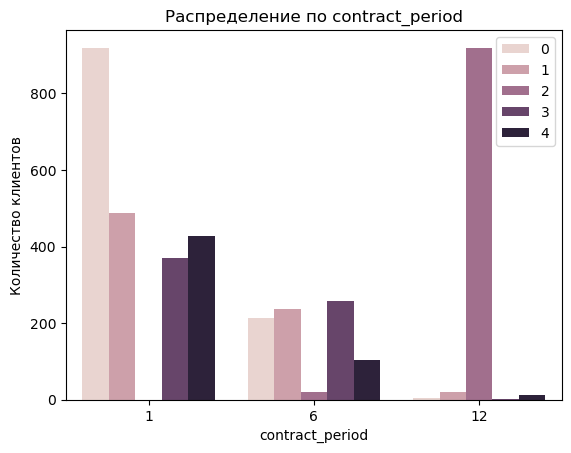

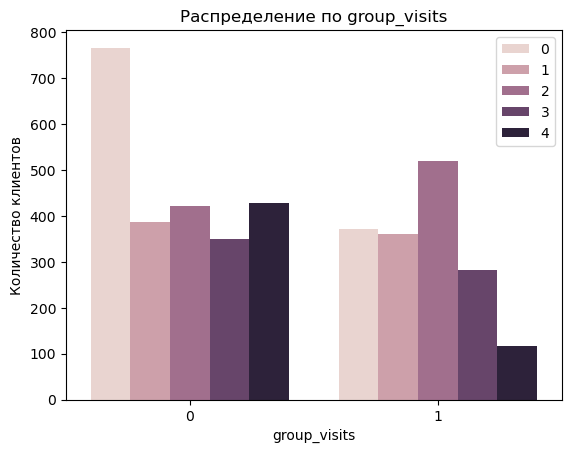

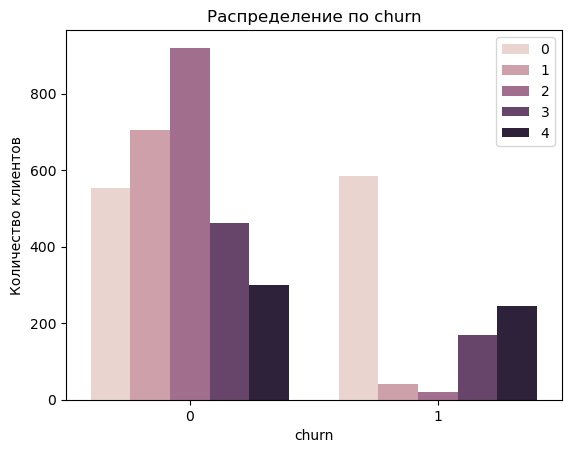

In [67]:
values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period','group_visits', 'churn']
fig, ax = plt.subplots()
for column in values:
    plt.title(column)
    sns.countplot(data=data, x=column, hue='cluster_km')
    plt.title ('Распределение по ' + column)
    plt.ylabel('Количество клиентов')
    plt.legend()
    plt.show()

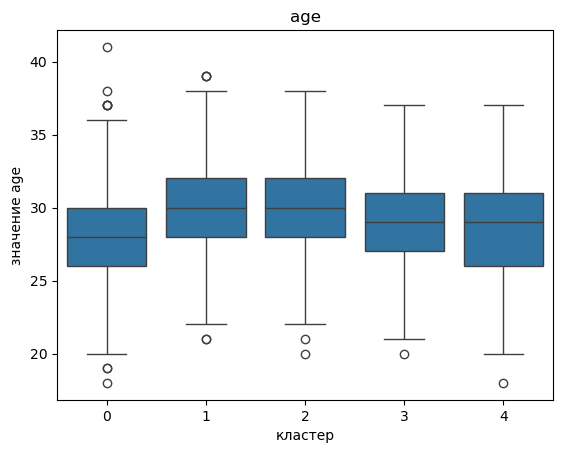

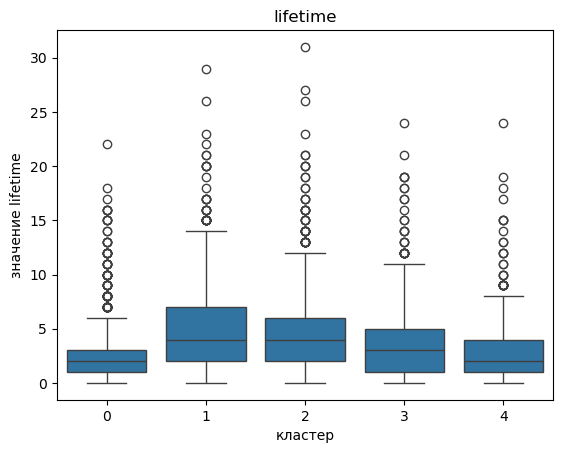

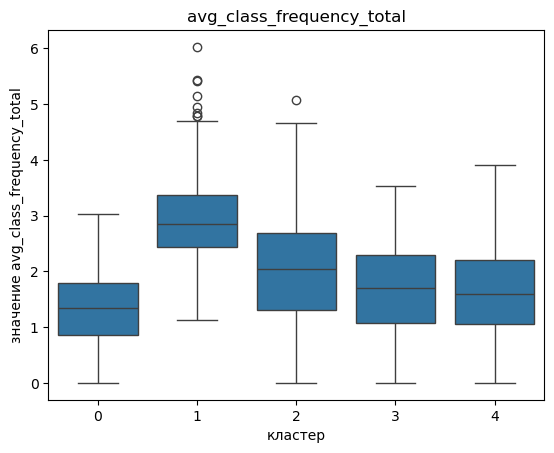

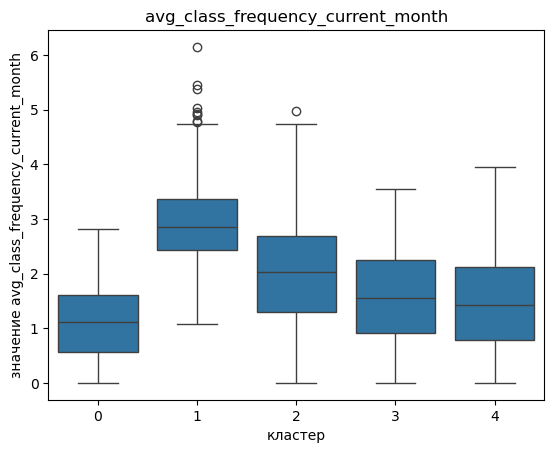

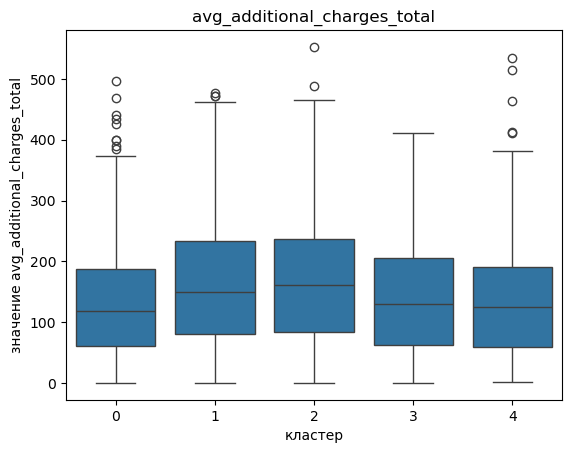

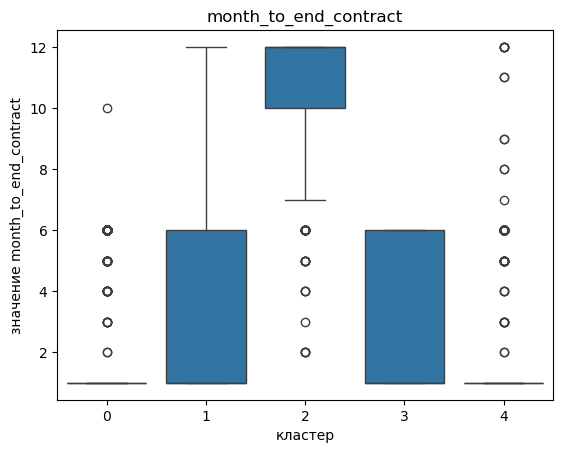

In [69]:
values = ['age', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total','month_to_end_contract']
fig, ax = plt.subplots()
for column in values:
    plt.title(column)
    sns.boxplot(data=data, x='cluster_km', y=column)
    plt.xlabel('кластер')
    plt.ylabel('значение '+ column)
    plt.show()

Выделим портреты клиентов по кластерам. Признак gender учитывать не будем, так как он распредлен примерно одинаково. Признак age также не будет учитываться, потому что клиенты рассматриваемые в данном случае находятся примерно в одной возрастной категории. 

Нулевой кластер:
1. Клиенты проживают в непосредственной близости от фитнес-клуба;
2. Практически не имеют ничего общего с акцией "приведи друга";
3. Здесь тоже в освном преобладают краткосрочные контракты сроком чуть больше 1 месяца;
4. Групповые занятия им тоже не интересны;
5. Самая высокая доля оттока;
6. Клиенты посещают клуб реже всех других кластеров;
7. Клиенты меньше всех тратят на дополнительные услуги.

Первый кластер: 
1. Клиенты живут недалеко;
2. Тоже заключают краткосрочные контракты, в основном на 2 месяца. Но самая большая доля на 6 месяцев приходится на этот кластер (можно развивать);
3. Интерес к групповым занятиям 50 на 50;
4. Занимает второе место по минимальной доле оттока после нулевого кластера;
5. В среднем посещают занятия около трех раз в неделю;
6. Есть интерес к дополнительным затратам в фитнес-клубе.

Второй кластер: 
1. Клиенты проживают дальше всех от фитнес-клуба;
2. Доля клиентов, работающих в компаниях-парнерах равна обычным клиентам и ниже чем в нулевом кластере;
3. Практически не имеют ничего общего с акцией "приведи друга";
4. Контракты в основном заключают сроком на месяц;
5. Групповые занятия им тоже не интересны;
6. Высокая доля оттока;
7. Клиенты посещают клуб в среднем чуть меньше двух раз в неделю.

Третий кластер:
1. Клиенты проживают в непосредственной близости от фитнес-клуба;
2. Среди клиентов нулевого кластера больше всего сотрудников, работающих в компаниях-партнерах;
3. Клиенты имеют абонементы сроком практически на один год;
4. Клиенты имеют самую низкую долю оттока среди всех кластеров;
5. Клиенты посещают клуб в среднем два раза в неделю;
6. Клиенты больше всех тратят на дополнительные услуги.

Четвертый кластер: 
1. Клиенты проживают чуть дальше, чем клиенты нулевого кластера;
2. Доля клиентов, работающих в компаниях-парнерах равна обычным клиентам и ниже чем в нулевом кластере;
3. Клиенты не оставляли номер телефона;
4. Чаще всего заключают контракт до 1 месяца, доля контрактов намного ниже чем в нулевом кластере (да и кластер самый маленький по числу клиентов);
5. Групповые занятия чаще не посещают;
6. Доля оттока выше, чем у нулевого кластера;
7. Клиенты посещают клуб в среднем чуть меньше двух раз в неделю;
8. Контракты заключаются сроком до полугода.

На мой взгляд самым перспективным является второй кластер, после него первый. 

### Доля оттока для каждого кластера

In [72]:
#найдем количество "отвалившихся" клиентов для каждого кластера
cluster_churn = data.query('churn==1').groupby('cluster_km')['churn'].count()
cluster_churn

cluster_km
0    584
1     41
2     21
3    170
4    245
Name: churn, dtype: int64

In [74]:
#найдем суммарное число "отвалившихся" клиентов
sum_churn = data.query('churn==1')['churn'].count()
sum_churn

1061

In [76]:
round(data.groupby('cluster_km')['churn'].mean(),2)

cluster_km
0    0.51
1    0.05
2    0.02
3    0.27
4    0.45
Name: churn, dtype: float64

Самая миниальная доля оттока у второго кластера и равняется 0.02. Далее идет первый кластер с долей оттока 0.05. Самый высокий отток у нулевого кластера - 0.51.

## Выводы и рекомендации

Был проведен анализ данных фитнес-центра. Первоначально данные были загружены и была выполнена перчиная предобработка данных, в ходе которой не было обнаружено дубликатов, пропусков и выбросов. Далее проверили исследовательский анализ данных (EDA). Выделили для себя важные признаки для анализа, такие как contract_period, Avg_class_frequency_total, Lifetime. Построили матрицу корреляций и выявили, что все, кроме одного признака gender имеют отрицательную корреляцию с нашей целевой переменной churn.

Далее построили две модели прогнозирования оттока клиентов - логистической регрессии и случайного леса. Стандартизировали данные, обучили модель и посчитали метрики. Согласно полученным данным значения метрик для двух моделей практически одинаковы, совсем немного лучше у логистической регрессии. 

После провели кластеризацию клиентов, построили дендрограмму, которая выделила 4 класса. Обучили модель кластеризации на основании алгоритма K-Means, обозначив количество кластеров равное 5 (согласно постановке задачи). Оценили распределение признаков для кластеров и выделили нулевой кластер как самый перпективный. 

Рекомендации по работе с клиентами: 
1. Исследование показало, что хорошо удерживают клиентов годовые абонементы. Возможно, стоит сделать акцию на них, либо добавить тариф заморозки, например на месяц (если кто-то уедет на Бали).
2. Эта рекомендация будет частично связана с предыдущей и относится к расположению. Часто бывает, что становится лень ездить, либо неудобно. Можно ввести функцию посещения нескольких или всех центров по абонементу, купленному на длительный срок, так как это сеть. 
3. Поднять уровень посещения зала до 2-3 стабильных раз в неделю, что не будет вызывать перегрузки для человека. Мотивировать можно системой лояльности. В целом следует ввести систему лояльности для постоянных клиентов, возможно сделать приложение, где можно будет отслеживать свой прогресс и записываться на групповые занятия. 
4. Если клиента не привлекают групповые занятия, то без опыта можно быстро потерять мотивацию на самостоятельных занятиях. Поэтому можно сделать пробные занятия с тренером, либо специальный лояльный тариф на сопровождение. 